In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import math
import lightning as L
from lightning import Trainer
from torchinfo import summary

In [2]:
default_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [3]:
train_data = datasets.ImageFolder("./pizza_steak_sushi/train", transform=default_transforms )
test_data = datasets.ImageFolder("./pizza_steak_sushi/test", transform= default_transforms)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True, num_workers=5, persistent_workers=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, pin_memory=True, num_workers=2)

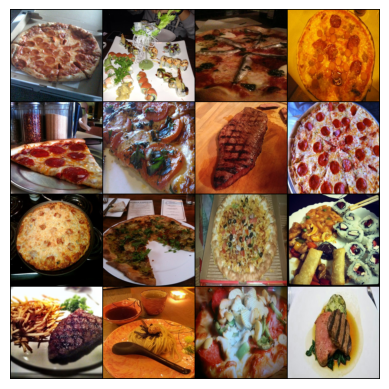

In [4]:
images , labels = next(iter(train_loader))
plt.imshow(make_grid(images, nrow= 4).permute(1,2,0))
plt.axis("off");

In [45]:

class PositionEmbedding(nn.Module):
    def __init__(self, embed_dim = 768, seq_len = 197):
        super().__init__()
        scale_factor = torch.exp(-math.log(10000) * torch.arange(0,embed_dim, 2)/embed_dim).reshape(-1, embed_dim//2)
        sequence = torch.arange(0, seq_len, 1).reshape(seq_len, -1)  # 
        pos_embed = torch.zeros((seq_len, embed_dim))
        pos_embed[:, 0:embed_dim:2] = torch.sin(sequence*scale_factor)
        pos_embed[:, 1: embed_dim:2 ] = torch.cos(sequence* scale_factor)
        self.register_buffer('pos_embed', pos_embed.unsqueeze(0))
    def forward(self, x):
        return self.pos_embed[:, :x.size(1), :]

In [46]:
class Feed_Forward_Block(nn.Module):
    def __init__(self, d_model=768, d_ff= 3072, dropout= 0.1):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(self.norm(x)))))

In [47]:
class Encoder_Block(nn.Module):
    def __init__(self, d_model = 768, dropout=0.1):
        super().__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.attn_block = nn.MultiheadAttention(d_model, 12, dropout, batch_first=True)
        self.linear = Feed_Forward_Block()
    def forward(self,x):
        x = self.layernorm(x)
        attn_output, _ = self.attn_block(x,x,x)
        x = self.linear(attn_output)
        return x

In [56]:
class ViT(L.LightningModule):
    def __init__(self, embed_dim = 768, dropout= 0.1, num_layers = 12, num_classes=3):
        super().__init__()
        self.embed_dim = embed_dim
        self.patch_embedding= nn.Conv2d(3, embed_dim, 16, 16, 0)
        self.position_embedding= PositionEmbedding()
        self.class_token = nn.Parameter(data = torch.ones(1, 1, embed_dim), requires_grad=True)
        self.dropout= nn.Dropout(dropout)
        self.encoder = nn.Sequential(*[Encoder_Block() for _ in range(num_layers)])
        self.classification = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim,num_classes))
    def forward(self,x):
        x = self.patch_embedding(x).view(-1,768,196).permute(0,2,1) # (batch_size, 196, 768)
        x = torch.cat((x, self.class_token.expand(x.size(0),-1,-1)), dim=1) # (batch_size, 197, 768)
        x = x + self.position_embedding(x)
        for layer in self.encoder:
            x = layer(x)
        out  = x[:,-1,:].view(-1, self.embed_dim)  # (batch_size, 1, embed_dim)
        out = self.classification(out) # (batch_size, num_classes)
        return out
    def training_step(self, batch, batch_idx):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        self.log("loss", loss, prog_bar=True, on_epoch=True, on_step=True)
        return loss
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr=0.003)
        return optimizer

In [57]:
# 197*768 are non learnable in our case, but learnable in original ViT
(4723968 + 2362368 + 1536)*12 + 590592 + 768 + 1536 + 2307 + 197*768

85800963

In [58]:
model = ViT()
summary(model, input_size= (32,3,224,224),col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ViT                                      [32, 3, 224, 224]         [32, 3]                   768                       True
├─Conv2d: 1-1                            [32, 3, 224, 224]         [32, 768, 14, 14]         590,592                   True
├─PositionEmbedding: 1-2                 [32, 197, 768]            [1, 197, 768]             --                        --
├─Sequential: 1-3                        --                        --                        --                        True
│    └─Encoder_Block: 2-1                [32, 197, 768]            [32, 197, 768]            --                        True
│    │    └─LayerNorm: 3-1               [32, 197, 768]            [32, 197, 768]            1,536                     True
│    │    └─MultiheadAttention: 3-2      [32, 197, 768]            [32, 197, 768]            2,362,368                 True
│    

In [60]:
model = ViT()

In [62]:

trainer = Trainer(max_epochs=4,log_every_n_steps=2)
trainer.fit(model, train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name               | Type              | Params
---------------------------------------------------------
0 | patch_embedding    | Conv2d            | 590 K 
1 | position_embedding | PositionEmbedding | 0     
2 | dropout            | Dropout           | 0     
3 | encoder            | Sequential        | 85.1 M
4 | classification     | Sequential        | 3.8 K 
  | other params       | n/a               | 768   
---------------------------------------------------------
85.6 M    Trainable params
0         Non-trainable params
85.6 M    Total params
342.599   Total estimated model params size (MB)


Epoch 3: 100%|██████████| 15/15 [00:11<00:00,  1.31it/s, v_num=22, loss_step=1.310, loss_epoch=1.260]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s, v_num=22, loss_step=1.310, loss_epoch=1.260]


In [63]:
model.eval()
correct, total = 0,0
with torch.no_grad():
    for images, labels in test_loader:
        output = model(images)
        pred = output.argmax(dim=1)
        correct += pred.eq(labels).sum().item()
        total += len(labels)
accuracy = correct/total*100
print(f"{accuracy=}")

accuracy=25.333333333333336


In [69]:
summary(pretrained_vit, input_size=(32,3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [32, 3]                   768
├─Conv2d: 1-1                                 [32, 768, 14, 14]         (590,592)
├─Encoder: 1-2                                [32, 197, 768]            151,296
│    └─Dropout: 2-1                           [32, 197, 768]            --
│    └─Sequential: 2-2                        [32, 197, 768]            --
│    │    └─EncoderBlock: 3-1                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-2                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-3                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-4                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-5                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-6                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-

In [78]:

pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
pretrained_vit.heads = nn.Linear(768,3)

class Vit_pretrained(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.vit= pretrained_vit
    def forward(self,x):
        return self.vit(x)
    def training_step(self, batch, batch_idx):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        self.log("loss", loss, prog_bar=True, on_epoch=True, on_step=True)
        return loss
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr=0.003)
        return optimizer

In [79]:
model = Vit_pretrained()
trainer = Trainer(max_epochs=4,log_every_n_steps=2)
trainer.fit(model, train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type              | Params
-------------------------------------------
0 | vit  | VisionTransformer | 85.8 M
-------------------------------------------
2.3 K     Trainable params
85.8 M    Non-trainable params
85.8 M    Total params
343.204   Total estimated model params size (MB)


Epoch 3: 100%|██████████| 15/15 [00:04<00:00,  3.57it/s, v_num=23, loss_step=0.320, loss_epoch=0.0721] 

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 15/15 [00:04<00:00,  3.34it/s, v_num=23, loss_step=0.320, loss_epoch=0.0721]


In [80]:
model.eval()
correct, total = 0,0
with torch.no_grad():
    for images, labels in test_loader:
        output = model(images)
        pred = output.argmax(dim=1)
        correct += pred.eq(labels).sum().item()
        total += len(labels)
accuracy = correct/total*100
print(f"{accuracy=}")

accuracy=93.33333333333333
